In [2]:
from model.BrownianBridge.LatentBrownianBridgeModel import LatentBrownianBridgeModel 
from model.VQGAN.vqgan import VQModel 
import torchvision.transforms as transforms
from PIL import Image
# from model.reg.reg import Reg, Transformer_2D

import torch 
# checkpoint = '/mnt/disk3/tiennh/taming-transformers/logs/2023-09-14T22-05-12_custom_vqgan/checkpoints/last.ckpt' 

/root/anaconda3/envs/BBDM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
from runners.base.EMA import EMA
# w_extract_features.ipynb

In [11]:
import yaml
import argparse 
import omegaconf.dictconfig
import os
f = open('configs/Template_CPDM.yaml', 'r')
dict_config = yaml.load(f, Loader=yaml.FullLoader)

IMAGE_SIZE = (256,256)
MAX_PIXEL = 2047

transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.0),
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor()
        ])

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict) or isinstance(value, omegaconf.dictconfig.DictConfig):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

nconfig = dict2namespace(dict_config)
nconfig.model.model_load_path = 'results1/229_conditional_LBBDM_segment_atten_2encoders/LBBDM-f4/checkpoint/top_model_epoch_48.pth'
nconfig.training.device = 'cuda'

vq = VQModel(**vars(nconfig.model.VQGAN.params))
model = LatentBrownianBridgeModel(nconfig.model)


# model.vqgan = vq.eval()



Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /home/PET-CT/vqgan/vq1_3_69.ckpt
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /home/PET-CT/vqgan/vq1_3_69.ckpt
load vqgan from /home/PET-CT/vqgan/vq1_3_69.ckpt
Spatial Rescaler mapping from 1 to 3 channels after resizing.
Spatial Rescaler mapping from 1 to 3 channels after resizing.


In [12]:
def load_model_from_checkpoint(config, net):
    model_states = None
    # if config.model.__contains__('model_load_path') and config.model.model_load_path is not None:
    print(f"load model {config.model.model_name} from {config.model.model_load_path}")
    model_states = torch.load(config.model.model_load_path, map_location='cpu')

    global_epoch = model_states['epoch']
    global_step = model_states['step']

    # load model
    
    ema = EMA(config.model.EMA.ema_decay)
    update_ema_interval = config.model.EMA.update_ema_interval
    start_ema_step = config.model.EMA.start_ema_step
    ema.register(net)

    net.load_state_dict(model_states['model'])
    # R_A.load_state_dict(model_states['reg'])
   
    # Load EMA
    if config.model.EMA.use_ema:
        ema.shadow = model_states['ema']
        ema.reset_device(net)
        ema.apply_shadow(net)
        
    net = net.to(config.training.device)
    
    return net, ema 

model, ema = load_model_from_checkpoint(nconfig, model)

load model LBBDM-f4 from results1/229_conditional_LBBDM_segment_atten_2encoders/LBBDM-f4/checkpoint/top_model_epoch_48.pth


In [13]:
def sample_to_eval( net, y, y_name, config):
    to_normal = config.data.dataset_config.to_normal

    with torch.no_grad():
        y = y.to(config.training.device)
        net = net.to(config.training.device)
        out_samples, one_step_samples, _ = net.sample(y, [y_name], 'val_step', clip_denoised=False, sample_mid_step=True)
            
        return out_samples, one_step_samples 

In [6]:
def tensor2image(tensor_img, max_pixel=32767):
    image = tensor_img.squeeze(0).detach().clone()
    image = image.mul_(0.5).add_(0.5).clamp_(0, 1.)
    np_image = image.mul_(max_pixel).add_(0.2).clamp_(0, max_pixel).permute(1, 2, 0).to('cpu').numpy()
    return np_image 
    
def plot_samples(sequences, number=5, dis=10, max_pixel=32767):
# convert tensor to numpy
    sequences = [tensor2image(seq, max_pixel=max_pixel) for seq in sequences]
    fig, axs = plt.subplots(1, number, figsize=(number * 4, 4))
    for i in range(number):
        axs[i].imshow(sequences[dis * i].squeeze(2), cmap='gray')
        axs[i].axis('off')
        # print(sequences[i].shape)
    plt.show()

import imageio

def plot_samples_as_gif(sequences, number=5, dis=10, max_pixel=32767, gif_path='output.gif'):
    # Convert tensor to numpy
    sequences = [tensor2image(seq, max_pixel=max_pixel) for seq in sequences]
    
    # Initialize list to store frames
    frames = []
    
    for i in range(number):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(sequences[dis * i].squeeze(2), cmap='gray')
        ax.axis('off')
        
        # Save the current frame to a temporary buffer
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        plt.close(fig)
    
    # Create and save the GIF
    imageio.mimsave(gif_path, frames, duration=0.5)

# Usage




In [ ]:
def tensor2image(tensor_img, max_pixel=32767):
    image = tensor_img.detach().clone()
    image = image.mul_(0.5).add_(0.5).clamp_(0, 1.)
    np_image = image.mul_(max_pixel).add_(0.2).clamp_(0, max_pixel).permute(1, 2, 0).to('cpu').numpy()
    return np_image 

In [7]:
import torch 
import numpy as np  

index = 14100
x_np = np.load(f'/home/PET-CT/splited_data_15k/test/A/{index}.npy', allow_pickle=True)
x_np = x_np / float(MAX_PIXEL)
image = Image.fromarray(x_np)
x = transform(image)
x = x.unsqueeze(0)
model.eval()
out_samples, one_step_samples = sample_to_eval(model, x, index, nconfig)

save one step sample mid steps: 100%|██████████| 200/200 [00:05<00:00, 38.19it/s]


In [8]:
one_step_samples[0].shape

torch.Size([1, 1, 256, 256])

In [30]:
pet_np = np.load(f'/home/PET-CT/splited_data_15k/test/B/{index}.npy', allow_pickle=True)


pet_np = pet_np / float(32767)
pet_img = Image.fromarray(pet_np)
pet_img = transform(pet_img) 
pet_img = (pet_img - 0.5) * 2.
pet_img = pet_img.unsqueeze(0)
pet_img = pet_img.to(nconfig.training.device)
# pet_latent = model.encode(pet_img)
# pet_latent_img = pet_latent.squeeze(0).detach().clone()
# pet_latent_np = pet_latent_img.permute(1, 2, 0).to('cpu').numpy()
# # pet_latent_np = (pet_latent_np/2) + 0.5 
# plt.imshow(pet_latent_np)
# plt.axis('off')

In [31]:
pet_pre = one_step_samples[0].to(nconfig.training.device)
Trans = R_A (pet_pre, pet_img)
SysRegist_A2B = spatial_transform(pet_pre,Trans)

In [32]:
Trans.shape
one_step_samples[0].shape


torch.Size([1, 1, 256, 256])

In [33]:
registered = tensor2image(SysRegist_A2B.detach().clone())
pet_pre = tensor2image(pet_pre.detach().clone())
registered.shape

(256, 256, 1)

In [34]:
registered.squeeze(2).shape

(256, 256)

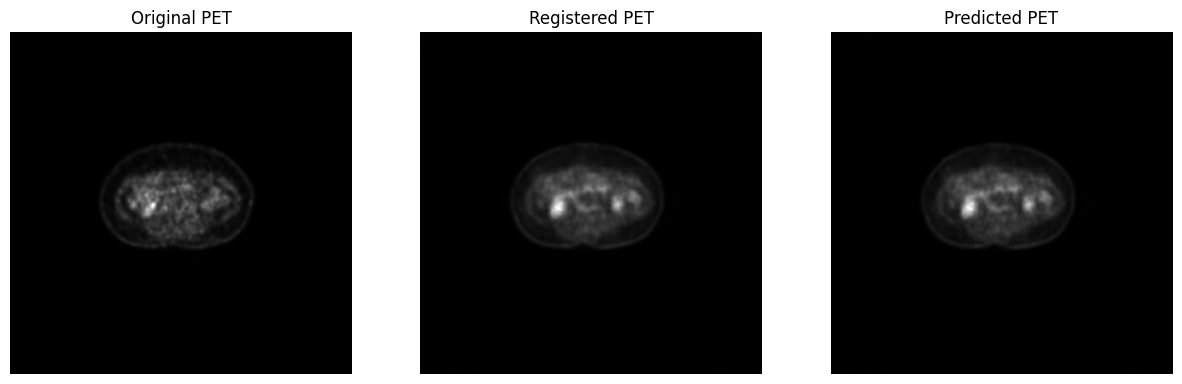

In [35]:

# plot the original PET image, the registered PET image, and the predicted PET image
def plot_images(pet_np, registered, pet_pre, save_path):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(pet_np, cmap='gray')
    axs[0].set_title('Original PET')
    axs[0].axis('off')

    axs[1].imshow(registered.squeeze(2), cmap='gray')
    axs[1].set_title('Registered PET')
    axs[1].axis('off')

    axs[2].imshow(pet_pre.squeeze(2), cmap='gray')
    axs[2].set_title('Predicted PET')
    axs[2].axis('off') 
    plt.savefig(save_path)


In [37]:
Trans.shape

torch.Size([1, 2, 256, 256])

In [43]:

deformation_field = Trans[0].permute(1, 2, 0).detach().clone().cpu()

# Remove the batch dimension and convert to numpy
deformation_field = deformation_field.numpy()



# Extract the x and y displacement components
# dx = deformation_field[0]
# dy = deformation_field[1]

# # Create a grid for plotting
# x = np.arange(0, dx.shape[1])
# y = np.arange(0, dx.shape[0])
# x, y = np.meshgrid(x, y)

# # Plot the vector field
# plt.figure(figsize=(10, 10))
# plt.quiver(x, y, dx, dy, scale=1, scale_units='xy', angles='xy')
# plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
# plt.title('Deformation Field')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()


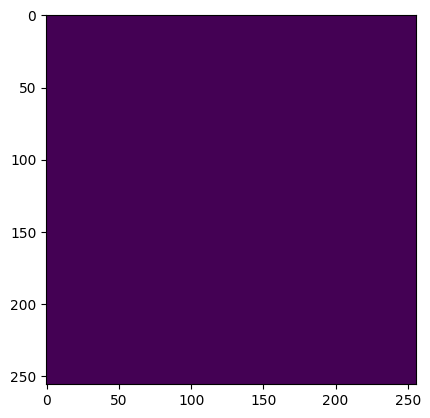

In [46]:
# deformation_field = deformation_field
plt.imshow(deformation_field[:,:,1])

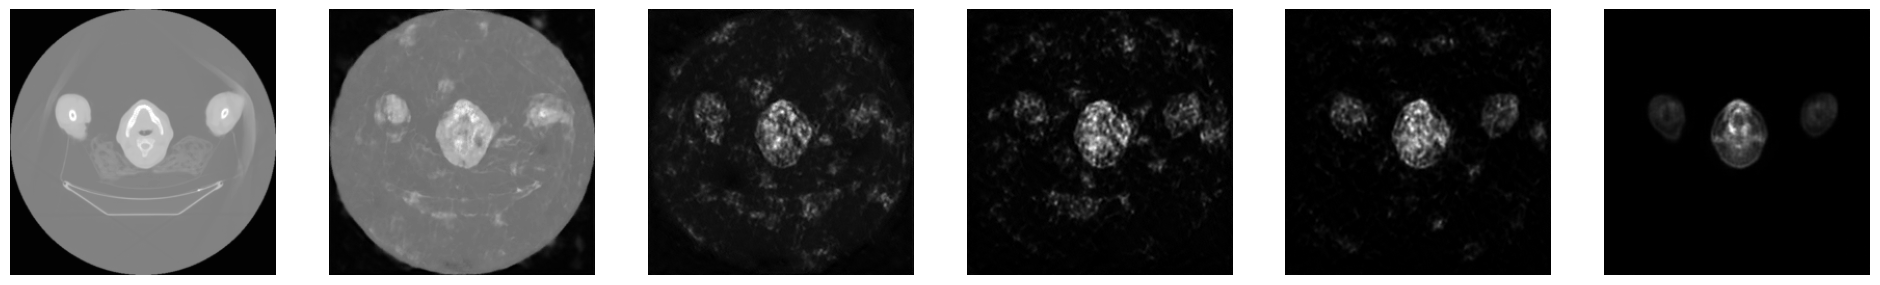

In [13]:
plot_samples(out_samples, 6, 40, MAX_PIXEL) 

tensor(518.2062)

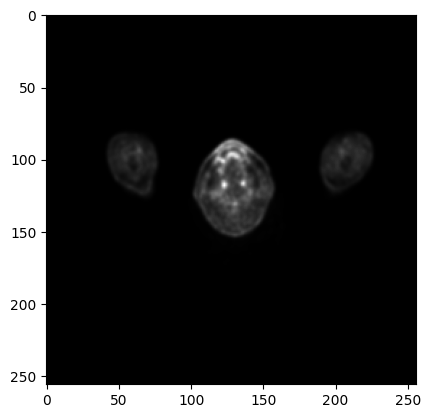

In [14]:
gt = np.load(f'/home/PET-CT/splited_data_15k/test/B/{index}.npy', allow_pickle=True)
plt.imshow(gt, cmap='gray')  
predict = out_samples[-1].squeeze()
# compute mae 
np.abs(predict - gt).mean()

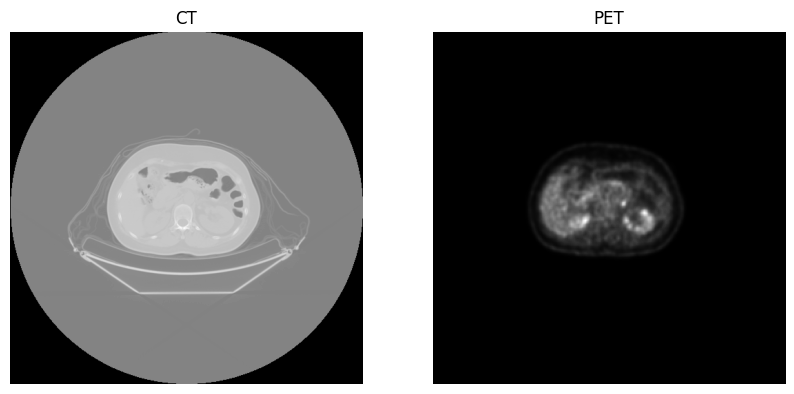

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
index = 14102 
ct_np = np.load(f'/home/PET-CT/splited_data_15k/test/A/{index}.npy', allow_pickle=True)
pet_np = np.load(f'/home/PET-CT/splited_data_15k/test/B/{index}.npy', allow_pickle=True)

# show pet and ct 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ct_np, cmap='gray')
axs[0].set_title('CT')
axs[0].axis('off')  

axs[1].imshow(pet_np, cmap='gray')
axs[1].set_title('PET')
axs[1].axis('off')
plt.show()


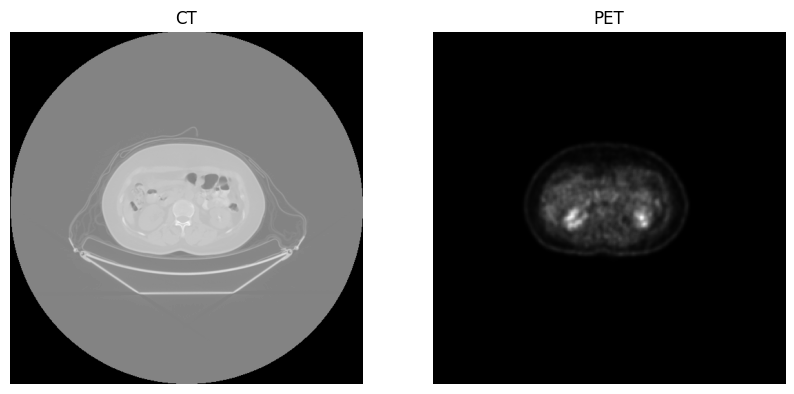

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
index = 14101
ct_np = np.load(f'/home/PET-CT/splited_data_15k/test/A/{index}.npy', allow_pickle=True)
pet_np = np.load(f'/home/PET-CT/splited_data_15k/test/B/{index}.npy', allow_pickle=True)

# show pet and ct 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ct_np, cmap='gray')
axs[0].set_title('CT')
axs[0].axis('off')  

axs[1].imshow(pet_np, cmap='gray')
axs[1].set_title('PET')
axs[1].axis('off')
plt.show()

In [1]:
ratio = "4040"

flatten_list = lambda nested_list: [
        item for sublist in nested_list for item in sublist
    ]
total_classes = list(range(1, 91))
divided_classes = [
    list(range(1, 46)),  # 45 classes
    list(range(46, 56)),  # 10 classes
    list(range(56, 66)),  # 10 classes
    list(range(66, 80)),  # 14 classes
    list(range(80, 91)),  # 11 classes
]

ratio_to_classes = {
    "4040": [divided_classes[0], flatten_list(divided_classes[1:])],
    "402020": [
        divided_classes[0],
        flatten_list(divided_classes[1:3]),
        flatten_list(divided_classes[3:]),
    ],
    "4010101010": divided_classes,
    "7010": [flatten_list(divided_classes[:-1]), divided_classes[-1]],
    "80": [total_classes, total_classes],
    "1010": [list(range(1, 11)), list(range(11, 22))],
    "20": [list(range(1, 22))],
}

divided_classes_detail = ratio_to_classes.get(ratio, total_classes)

In [7]:
r = ratio_to_classes.get(ratio)

In [8]:
len(r[0]), len(r[1])

(45, 45)